# Prelim

Notebook for 10X PBMC ATAC dataset: https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_10k_nextgem

<b>ArchR installation </b>

Install from [https://github.com/settylab/ArchR](https://github.com/settylab/ArchR)

```
library(devtools)
devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories())
```

Update your ArchR with the customized version
```
R CMD INSTALL -l <PATH to R personal library> <path to Git clone >
```

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.
Install MACS2 for peak celling 
```
conda install -c bioconda macs2 
```



## Load data

Download the following files:
1. [ATAC fragments file](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz)
2. [Index for the fragments file](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi)
3. [Per barcode metrics](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_singlecell.csv)
4. [Motifs file](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/motifs.tsv)

Use the above files to run ArchR using the ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-ATAC-standalone-ArchR-preprocessing.R


The outputs from ArchR are available to download from: 
`s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/`

Copy the results over to the `data/` directory using 
`aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/ data/pbmc_10x_atac/export/`

In [1]:
# Uncomment following line to download
#!aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/scatac/ArchR/ ../data/pbmc_10x_atac/export/

# Imports

In [2]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [5]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [6]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [7]:
data_dir = os.path.expanduser('../data/pbmc_10x_atac/export/')

Load all the exported results from ArchR

### Peaks data

In [8]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [9]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:752475-752975,chr1,752475,752975,501,*,107.26800,0.957,0.887,2,C14._.Rep1,LINC00115,8861,Distal,10176,uc001aau.3,0.4810,1,0
chr1:762714-763214,chr1,762714,763214,501,*,20.66550,0.957,0.887,2,C14._.Rep2,LINC01128,7,Promoter,6,uc021oeh.1,0.7026,2,0
chr1:773662-774162,chr1,773662,774162,501,*,2.80331,0.322,0.058,2,C7._.Rep2,LINC01128,10941,Intronic,10733,uc021oeh.1,0.4591,3,0
chr1:779830-780330,chr1,779830,780330,501,*,6.29453,0.312,0.141,2,C2._.Rep1,LINC01128,17109,Intronic,16901,uc021oeh.1,0.5150,4,0
chr1:800919-801419,chr1,800919,801419,501,*,69.04460,0.883,0.729,2,C3._.Rep1,FAM41C,2282,Distal,11012,uc021oei.1,0.4631,5,0


In [10]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/loc/scratch/7538045/ipykernel_29323/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [11]:
ad.X = ad.X.tocsr()

In [12]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

### SVD

In [13]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [14]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [15]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd'

### Gene scores

In [16]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [17]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [18]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'


Add the motifs.tsv to the Anndata to allow matching of motif names with TFs

In [19]:
ad.uns['motifs'] = pd.read_csv(data_dir + "motifs.tsv")

# Preprocessing

In [20]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

2023-01-13 16:12:43.538553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 16:12:43.673495: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 16:12:43.678411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 16:12:43.678425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [21]:
# Phenograph
warnings.filterwarnings('ignore')
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.405001163482666 seconds
Jaccard graph constructed in 3.8291118144989014 seconds
Wrote graph to binary file in 0.1919097900390625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.855583
After 2 runs, maximum modularity is Q = 0.857994
After 3 runs, maximum modularity is Q = 0.860559
After 4 runs, maximum modularity is Q = 0.861707
Louvain completed 24 runs in 10.721095561981201 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 27.66795015335083 seconds


# Visualizations

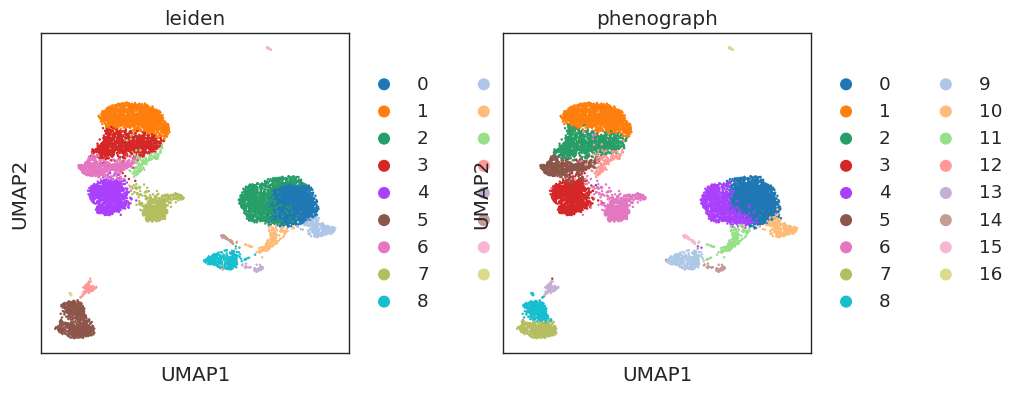

In [22]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

# Save

In [23]:
ad

AnnData object with n_obs × n_vars = 9489 × 155687
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'motifs', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'phenograph_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap'
    obsp: 'distances', 'connectivities'

In [24]:
ad.write(data_dir + '../../pbmc_10k_atac.h5ad')

# Coverage plots

## Functions

In [25]:
import tabix
import subprocess

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [26]:
def compute_coverage(fragments_file, region, barcodes, out_prefix, 
                     smooth=None, normalize=False, frag_type='All'):

    # Read file
    tb = tabix.open(fragments_file)
    # Query region
    records = tb.querys(region)

    # Bed file
    bed_file = open(out_prefix + '.bed', 'w')

    # Iterate and write bed file
    for record in records:
        if record[3] in barcodes:
            # Write to bed file if the read is NFR
            if frag_type == 'NFR' and int(record[2]) - int(record[1]) > 145:
                continue 
            if frag_type == 'NUC' and int(record[2]) - int(record[1]) <= 145:
                continue 
            
            # Write to bed file
            line = record[0] + '\t' + record[1] + '\t' + record[2] + '\n'
            bed_file.writelines(line)

    # Close bed file
    bed_file.close()

    # Region to bed
    line = region.replace(':', '\t').replace('-', '\t') + '\n'
    bed_file = open(out_prefix + '.region.bed', 'w')
    bed_file.writelines(line)
    bed_file.close()

    # Coverage
    out_file = open(out_prefix + '.coverage.bed', 'w')
    args = ['bedtools', 'coverage', '-a', out_prefix + '.region.bed', '-b',
            out_prefix + '.bed', '-d']
    subprocess.call(args, stdout=out_file)
    out_file.close()

    # Read coverage
    df = pd.read_csv(out_prefix + '.coverage.bed', sep='\t', header=None)
    coverage = pd.Series(df[4].values, index=df[1] + df[3] - 1)
    coverage.attrs['chr'] = df[0][0]

    # Smooth if specified
    if smooth:
        coverage = coverage.rolling(smooth).mean()
        coverage[coverage.isnull()] = coverage.iloc[smooth]

    if normalize:
        norm = 100 / len(barcodes)
        coverage = coverage * norm

    # Clean up
    os.unlink(out_prefix + '.bed')
    os.unlink(out_prefix + '.coverage.bed')
    os.unlink(out_prefix + '.region.bed')

    return coverage

In [27]:
# Plot coverage
def _plot_coverage(coverage, track_name='Coverage', ax=None, color='#ff7f00',
                   min_coverage=0, ylim=None, fill=True):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    # Plot and fill
    values = coverage
    values[values <= min_coverage] = 0
    if fill:
        ax.plot(coverage.index, values, color='black', linewidth=0.05)
        ax.fill_between(coverage.index, 0, values, color=color)
        ax.set_ylabel(track_name)
    else:
        ax.plot(coverage.index, values, color=color)

    # Scale
    if ylim is not None:
        ax.set_ylim(ylim)
    sns.despine(ax=ax)

    
# BED plot
def _plot_bed(plot_peaks, track_name="Bed", ax=None, facecolor='#ff7f00'):

    if ax is None:
        plt.figure()
        ax = plt.gca()
    
    rects = []
    if len(plot_peaks) > 0:
        for s, e in zip(plot_peaks.Start, plot_peaks.End):
            rects.append(Rectangle((s, -0.3), e - s, 0.6))

    # Add rectangles
    # Dummy scatter
    pc = PatchCollection(rects, facecolor=facecolor, edgecolor='black')
    ax.add_collection(pc)

    # Axis annotation
    ax.set_ylim([-1, 1])
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([])
    ax.set_ylabel(track_name)
    ax.axes.get_xaxis().set_visible(False)


# Gene plot
def _plot_gene(genes, ax=None, track_name='Genes', facecolor='#377eb8',
               exon_height=0.6, utr_height=0.25):
    # Setup plot
    if ax is None:
        plt.figure()
        ax = plt.gca()

    for gene in np.unique(genes.gene_name):
        gene_pr = genes[genes.gene_name == gene]

        # Plot lines
        gs, ge = gene_pr[gene_pr.Feature == 'gene'].Start.values[0], gene_pr[gene_pr.Feature == 'gene'].End.values[0]
        ax.plot([gs, ge], [0, 0], color='black')
        ax.set_ylim([-1, 1])
        ax.text((gs + ge) / 2,
                -(exon_height + utr_height), gene, horizontalalignment='center')

        # UTRs
        utrs = gene_pr[gene_pr.Feature.astype(str).str.contains('utr')]
        if len(utrs) > 0:
            rects = []
            for s, e in zip(utrs.Start, utrs.End):
                rects.append(Rectangle((s, -utr_height / 2), e - s, utr_height))
            ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # CDS
        cds = gene_pr[gene_pr.Feature.astype(str).str.contains('CDS')]
        if len(cds) == 0:
            cds = gene_pr[gene_pr.Feature.astype(str).str.contains('exon')]
        rects = []
        for s, e in zip(cds.Start, cds.End):
            rects.append(Rectangle((s, -exon_height / 2), e - s, exon_height))
        ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # Arrow indicating direction
        rs, re = ax.get_xlim()
        if gene_pr.stranded:
            s, e = cds.Start.values[0], cds.End.values[0]
            if gene_pr.Strand.values[0] == '+':
                ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
                ax.plot([e - (re - rs) / 100, e], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
                ax.plot([e - (re - rs) / 100, e], [-0.35, -0.65], color='red', linewidth=1, alpha=1)
            else:
                ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
                ax.plot([s + (re - rs) / 100, s], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
                ax.plot([s + (re - rs) / 100, s], [-0.35, -0.65], color='red', linewidth=1, alpha=1)

    # Axis clean up
    ax.set_ylabel(track_name)
    sns.despine(ax=ax)
    ax.set_yticks([])

In [28]:
def plot_coverage(barcode_groups, region, fragments_file,
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', normalize=True):

    # Determine coverages
    coverages = dict()
    for k in barcode_groups.index:
        iter_norm = normalize
        if k == 'Single-cell':
            iter_norm = False
        coverages[k] = compute_coverage(fragments_file, region, barcode_groups[k],
                                        '/tmp/test', smooth, iter_norm, frag_type)
    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed)

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
        ax.set_ylabel('Genes')
        sns.despine(ax=ax)
        ax.set_yticks([])


    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
    locs[0] += 10000
    locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])





## GTF

In [29]:
# Download hg19 gtf file from ENSEMBL (https://www.ensembl.org) and replace with the path
gtf = pr.read_gtf('/fh/fast/setty_m/grp/gtfs/hg19.gtf')

## Fragments file

In [30]:
# Download the fragments file and replace the path
fragments_file = '/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz'

In [31]:
# Cell names should be consistent with fragments file
ad.obs['FragSample'] = ad.obs_names.str.split('#').str.get(1)

## Barcode groups

In [32]:
# A track for each cluster
barcode_groups = pd.Series(dtype=object)
for cat in ['0', '1', '2', '4', '7', '10', '14', '16']:
    barcode_groups[f'Clstr {cat}'] = ad.obs['FragSample'][ad.obs['phenograph'] == cat].values

## Peaks

In [33]:
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(ad.var_names)

## Plot

In [34]:
# Pax5 locus 
region = 'chr21:36,160,098-36,421,595'.replace(',', '')
pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

genes = gtf.intersect(pr_region)

In [35]:
cluster_colors = pd.Series(ad.uns['phenograph_colors'], index=ad.obs['phenograph'].values.categories)
cluster_colors.index = 'Clstr ' + cluster_colors.index
cluster_colors = cluster_colors[barcode_groups.index]

In [36]:
!ml BEDTools
!module list


Currently Loaded Modules:
  1) Anaconda3/2022.05

 



In [37]:
import os
import subprocess
import warnings

module_name = 'BEDTools/2.30.0-GCC-11.2.0'

class LmodError(Exception):
    pass

lmod = os.environ.get('LMOD_CMD')
if lmod is None:
    raise LmodError('Environment variable "LMOD_CMD" not set. Is lmod available?')

cmd = [lmod, 'python', 'load', module_name]
process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)
stdout, stderr = process.communicate()

if process.returncode:
   raise LmodError(stderr.decode('utf-8'))
if stderr:
    warnings.warn(stderr.decode('utf-8'))
exec(stdout)

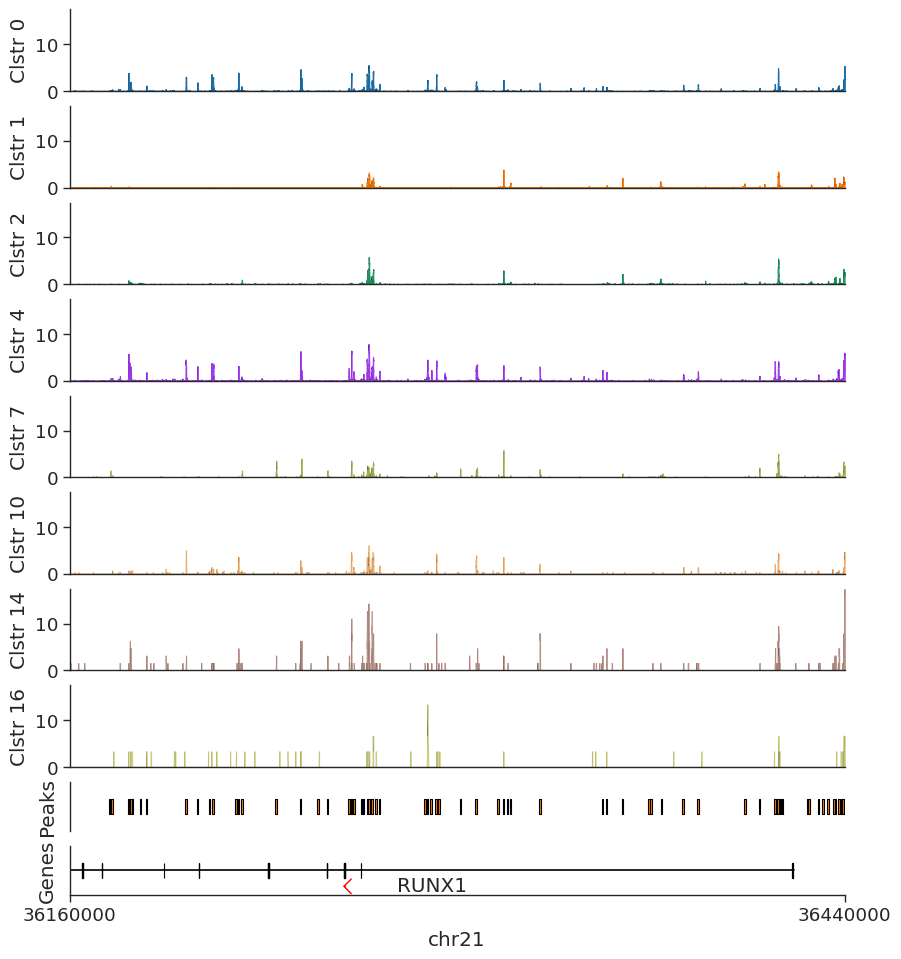

In [38]:
plot_coverage(barcode_groups, region, fragments_file, 
              peak_groups, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=1, coverage_colors=cluster_colors, 
             fig_width=10,  plot_cov_size = 1.25, frag_type='NFR', normalize=True)



# Motifs 

## Peak sequences

In [39]:
peaks_pr = pyranges_from_strings(ad.var_names)

### Export

In [40]:
motifs_dir = '../data/pbmc_10x_atac/motifs/'
os.makedirs(motifs_dir, exist_ok=True)

In [41]:
peaks_df = pd.DataFrame()
# Positionns
peaks_df['chrom'] = peaks_pr.Chromosome
peaks_df['chromStart'] = peaks_pr.Start
peaks_df['chromEnd'] = peaks_pr.End

# summit
peaks_df['summit']  = 250

# Score
peaks_df['score'] = 1

# Names
peaks_df['name'] = peaks_df['chrom'].astype(str) + ':' + peaks_df['chromStart'].astype(str) + '-' + peaks_df['chromEnd'].astype(str)

peaks_df.to_csv(motifs_dir + 'peaks.bed', sep='\t', index=None, header=True)

### Sequences

Run this in R

```
# Install and install SeqGL from here: https://github.com/ManuSetty/SeqGL
library(SeqGL)

span <- 150
org <- 'hg19'

# Peaks directory
motifs.dir <- './motifs/'
peaks.file <- sprintf("%speaks.bed", motifs.dir)

# Load peaks 
regions <- read.table (peaks.file, stringsAsFactors=FALSE, header=TRUE)
all.regions <- GRanges (regions[,'chrom'], IRanges (regions[,'chromStart'], regions[,'chromEnd']),
    score=regions[,'score'], summit=regions[,'summit'], name=regions[,'name'])
start (all.regions) <- end (all.regions) <- start (all.regions) + all.regions$summit - 1
all.regions <- resize (all.regions, fix='center', span)


# Identify sequences and flag any sequences with N
seqs <- SeqGL:::get.seqs (SeqGL:::load.bsgenome (org), all.regions)
names(seqs) <- all.regions$name
# Save 
writeXStringSet(seqs, sprintf("%s/all_seqs.fa", motifs.dir))
```

### FIMO

Install FIMO from here: https://meme-suite.org/meme/doc/fimo.html

```
fimo  -oc fimo  /fh/fast/setty_m/grp/motif_databases/CIS-BP_2.00/Homo_sapiens.meme all_seqs.fa 
```

### Matrix

In [42]:
import tqdm

fimo_res = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data/pbmc_10x_atac/fimo/fimo.tsv'

In [43]:
# Create matrix
# Motif information 
motifs = pd.Series()
motif_index = 0

# Peak index
peak_index = pd.Series(range(len(ad.var_names)), index=ad.var_names)

# Values
num_records = int(subprocess.run(['wc', '-l', fimo_res], stdout=subprocess.PIPE).stdout.decode().split(' ')[0]) - 5
x = np.zeros(num_records)
y = np.zeros(num_records)
values = np.zeros(num_records)

# Read file
rec_index = 0
for line in tqdm.tqdm(open(fimo_res, 'r')):
    # Skip first line 
    split = line.split('\t')
    if split[0] == 'motif_id':
        continue
    
    if len(split) == 1:
        break
        
    # Update motifs if necessary
    if split[1] not in motifs:
        motifs[split[1]] = motif_index
        motif_index += 1

    # Update record
    x[rec_index] = peak_index[split[2]]
    y[rec_index] = motifs[split[1]]
    values[rec_index] = float(split[6])
    rec_index += 1

11668837it [01:54, 102252.99it/s]


In [44]:
# Sparse matrix
from scipy.sparse import csr_matrix
pwm_scores = csr_matrix((values, (x, y)), (ad.shape[1], motif_index))
pwm_ad = sc.AnnData(pwm_scores)
pwm_ad.obs_names = ad.var_names
pwm_ad.var_names = motifs.index
pwm_ad.write(motifs_dir + 'fimo_pwm_scores.h5ad')

pwm_ad

AnnData object with n_obs × n_vars = 155687 × 1068